## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# Used to underline text in plots
from matplotlib import rc
# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
cor_mx_by_admunitid_directory = os.getcwd()

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
os.chdir(".."), os.chdir("..")   # move two directories up
%run color_scheme.ipynb
os.chdir("collect_data")
%run get_data.ipynb
os.chdir(cor_mx_by_admunitid_directory)    # return to original directory

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!


## Function to calculate the probability of correlations between two arrays

In [3]:
def sort_AdmUnitIDs_by_population_density():
    AdmUnitIDs = [e for e in covid19.keys()]
    AdmUnitIDs.sort()
    return AdmUnitIDs

In [4]:
# AdmUnitIds = list(covid19.keys())
AdmUnitIds = sort_AdmUnitIDs_by_population_density()

In [5]:
AdmUnitIDs_sorted_by_ID = ""
for AdmUnitID in AdmUnitIds:
    county_name = counties_geography[AdmUnitID]["name"]
    AdmUnitIDs_sorted_by_ID += AdmUnitID + "  " + county_name + "\n\n"

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Anhang")): os.makedirs("results/Anhang")
with open("results/Anhang/countiesIDs_sorted_by_ID.tex", "w") as file:
    file.write(AdmUnitIDs_sorted_by_ID)
os.chdir(cor_mx_by_admunitid_directory)    # return to original directory

In [6]:
def get_correlation_matrix(get_max_correlation_not_sum = True, max_shift = 50):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId in AdmUnitIds:
        for second_AdmUnitId in AdmUnitIds:
            i1, i2 = (AdmUnitIds.index(AdmUnitId), AdmUnitIds.index(second_AdmUnitId))
            # if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[i1][i2] != 0): continue    # Already set
            correlation = covid19[AdmUnitId]["correlation"][second_AdmUnitId]
            offset = max_shift + 1
            while get_max_correlation_not_sum and abs(offset) > max_shift:
                # get the shift with the highest correlation probability
                offset = non_county_specific_data[
                    "correlation_position_array2_to_array1"][np.argmax(correlation)]
                correlation[np.argmax(correlation)] = 0
            if not(get_max_correlation_not_sum):    # sum up all probabilities
                lc = len(correlation)//2
                offset = ((-sum(correlation[lc-max_shift:lc]) +
                          sum(correlation[lc+1:lc+max_shift+1]))/lc)
            correlation_matrix[i1][i2] = offset
            correlation_matrix[i2][i1] = -offset
    return correlation_matrix

In [7]:
correlation_matrizes = list()
matrix_configurations = [(False, 14), (True, 14), (False, 30),
                         (True, 30), (False, 50), (True, 50)]
for config in matrix_configurations:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

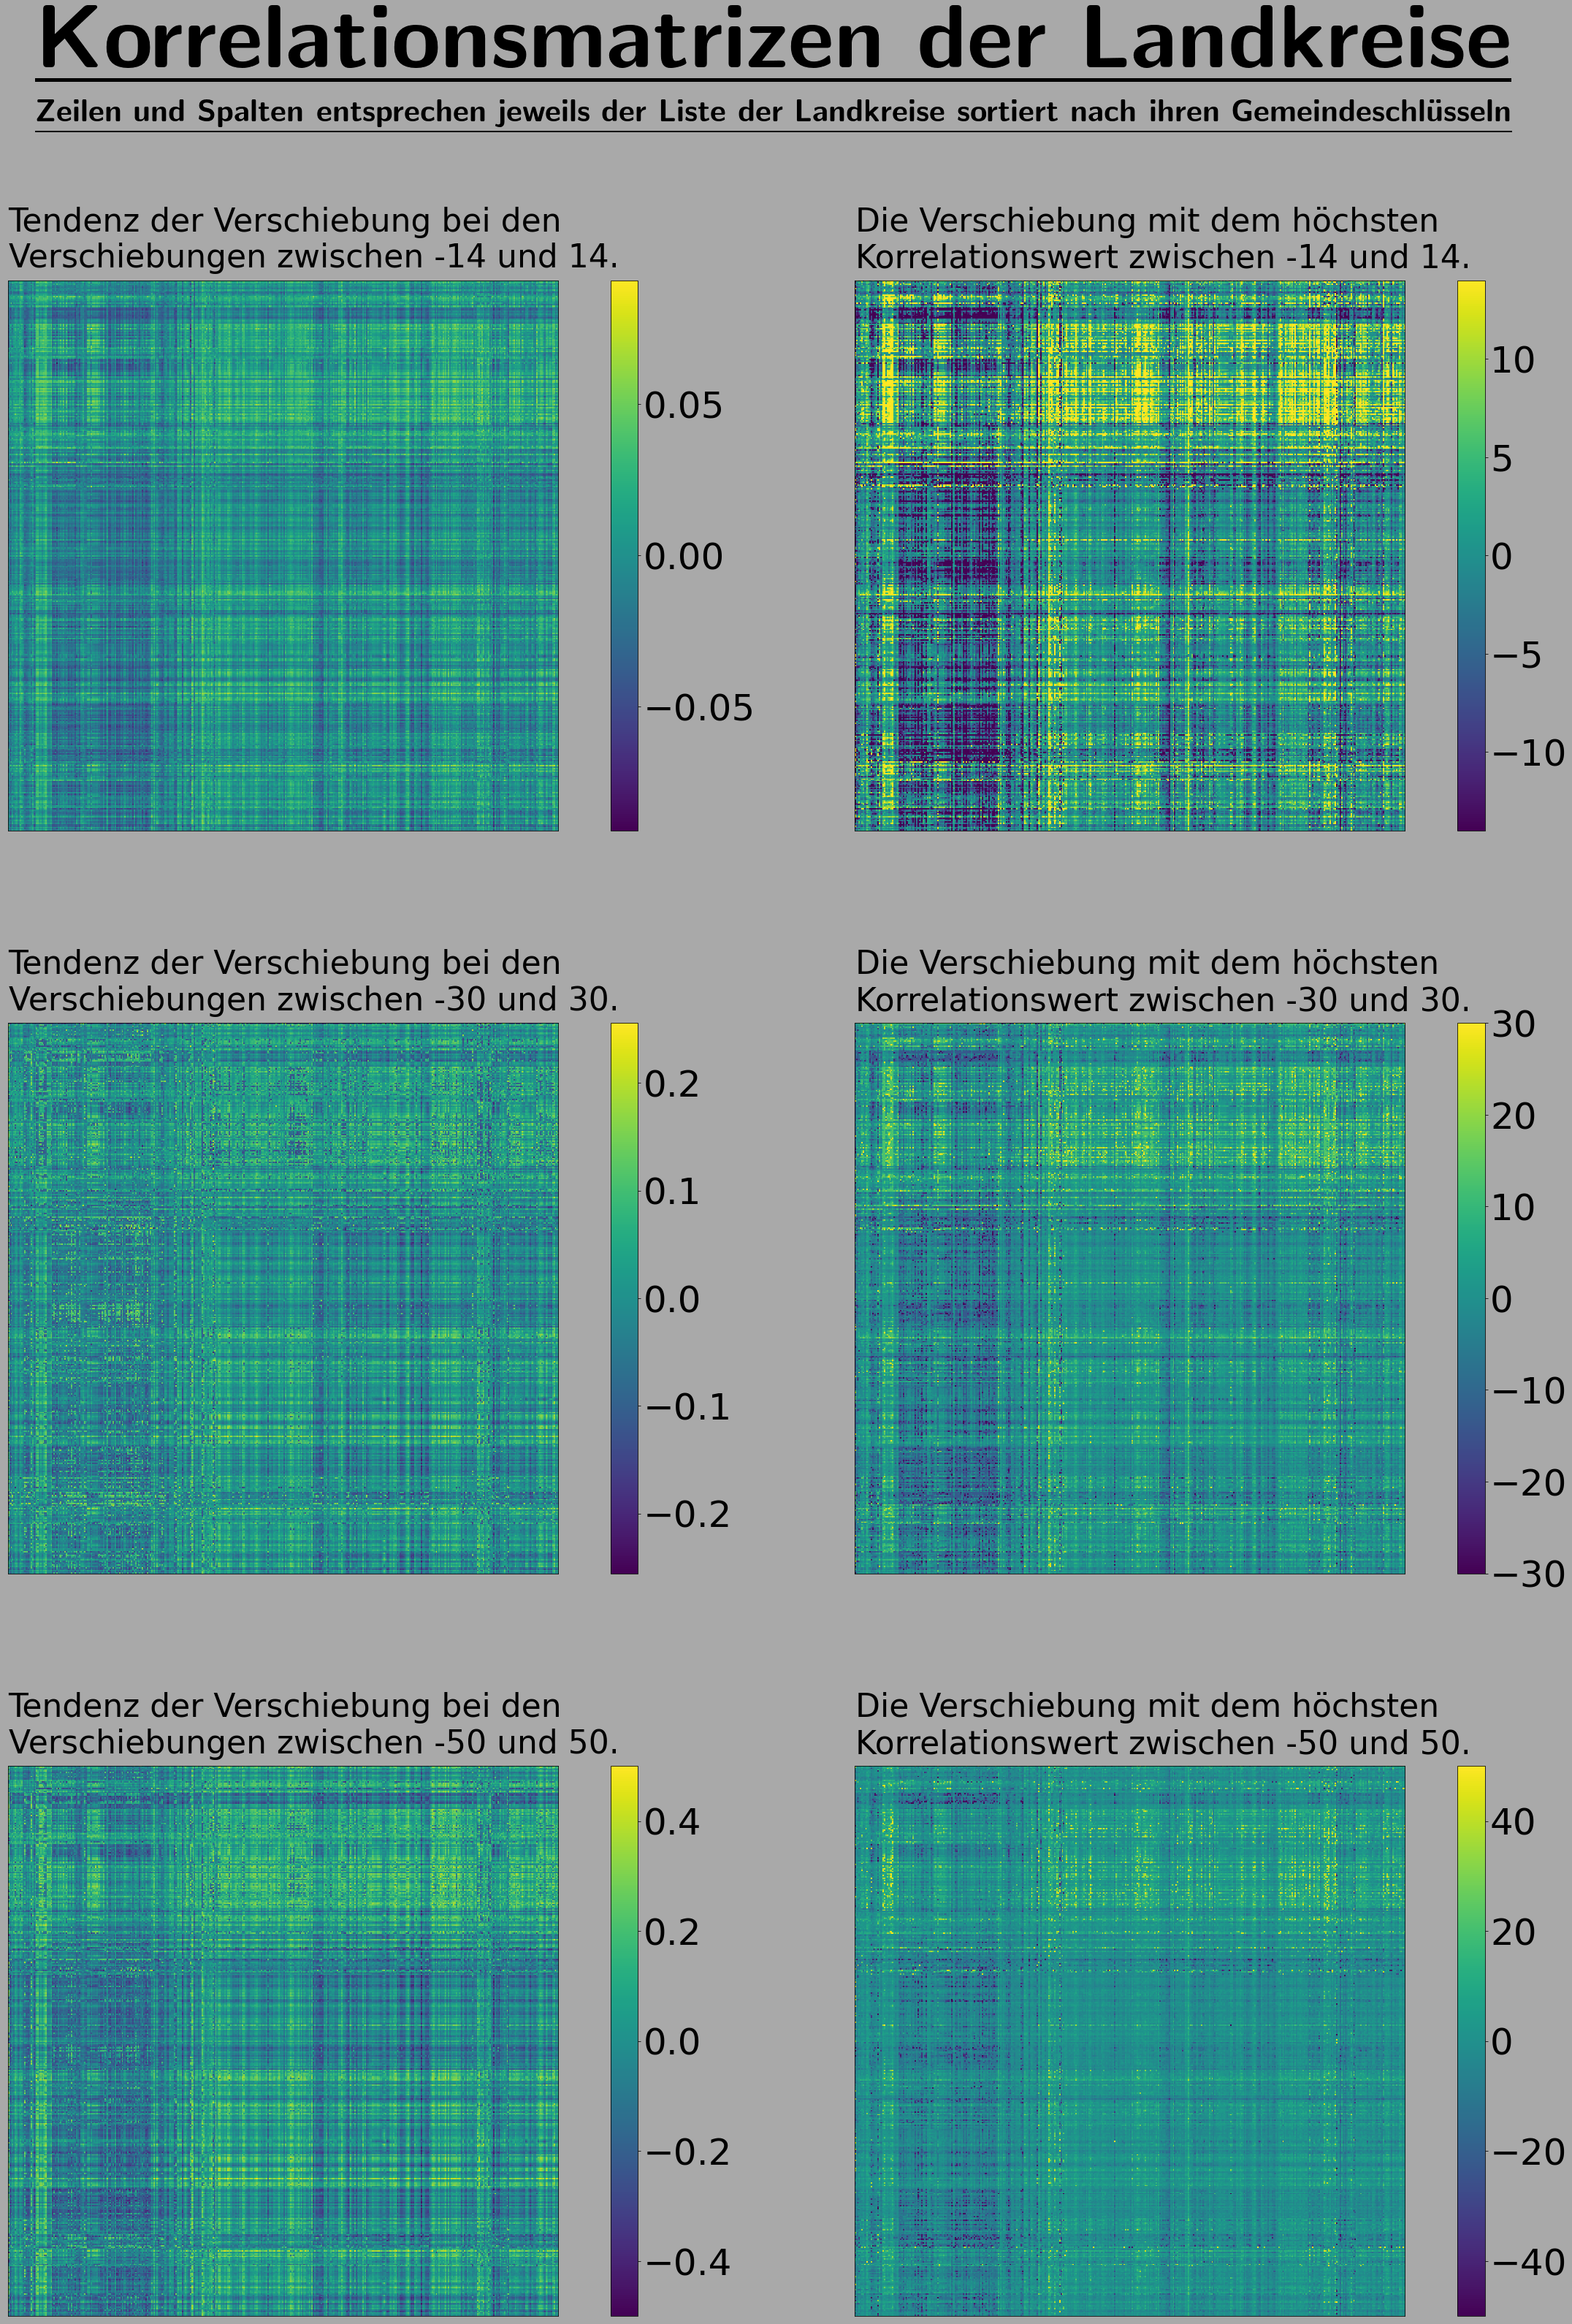

In [8]:
fig, ax = plt.subplots(3, 2, figsize = (30, 46), facecolor='darkgrey')
ax[0][0].text(20,-160,r'\textbf{\underline{Korrelationsmatrizen der Landkreise}}',
              fontsize=123, usetex=True)
ax[0][0].text(20,-120,r"\textbf{\underline{Zeilen und Spalten entsprechen }}" +
              r"\textbf{\underline{jeweils der Liste der Landkreise sortiert nach ihren Gemeindeschlüsseln}}",
              fontsize=43, usetex=True)

i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    if matrix_configurations[i][0]:
        shift = str(matrix_configurations[i][1])
        axis.text(0,-10,"Die Verschiebung mit dem höchsten\n" +
                        "Korrelationswert zwischen -"+shift+" und "+shift+".",
                        fontsize=44)
    else:
        shift = str(matrix_configurations[i][1])
        axis.text(0,-10,"Tendenz der Verschiebung bei den\n" +
                       "Verschiebungen zwischen -"+shift+" und "+shift+".",
                       fontsize=44)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=1)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
plt.tight_layout(w_pad=-100)
plt.savefig("results/Ergebnisse/matrizes_north_to_south_counties.png")
os.chdir(cor_mx_by_admunitid_directory)    # return to original directory